#### CS164 Final Project

### Constrained Optimization of Latent Distributions to Support Neural Network Training
_Yoav Rabinovich, Apr 2020_

-------------

Demonstrating the usefulness of constrained optimization of a latent distribution to support the training of image segmentation neural networks, as proposed in [Pathak et al., 2015](https://arxiv.org/abs/1506.03648). 

In this demonstration I used an undertrained network as a substitute to a network trained on a weakly labeled dataset, and applied foreground constraints to a latent distribution to demonstrate that the resultant distribution takes a step closer to the proper distribution.

Preprocessing and training code adapted from [fastai](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid-tiramisu.ipynb). 

#### Imports and Dataset

In [0]:
from fastai import *
from fastai.vision import *
import cvxpy as cp

In [0]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

#### Preprocessing

In [0]:
path = Path('SegNet-Tutorial/CamVid')

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# Function for locating class mask for each image
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# Scaling down the images for fewer constraints
SIZE = 50

In [0]:
# Defining dataset

src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=SIZE, tfm_y=True)
        .databunch(bs=8)
        .normalize(imagenet_stats))

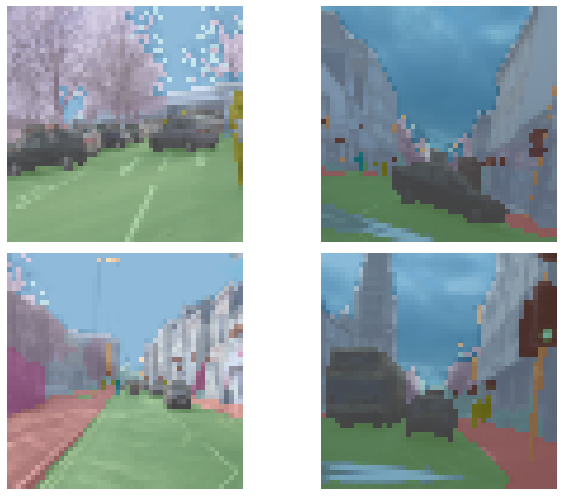

In [6]:
# Visualizing images and masks

data.show_batch(2, figsize=(10,7))

#### Undertaining model

In [0]:
# Defining an accuracy score

name2id = {v:k for k,v in enumerate(codes)}

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != name2id['Void']
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
# Building a UNet model pretrained on ResNet34

learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2, bottle=True)

In [9]:
# Fitting for once cycle of SGD

learn.fit_one_cycle(1, slice(1e-3), pct_start=0.8)
learn.save("undertrained")

epoch,train_loss,valid_loss,acc_camvid,time
0,1.282811,1.009026,0.662987,00:09


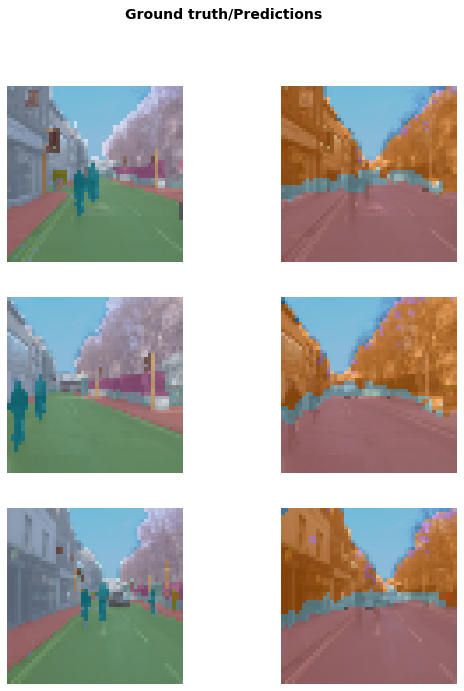

In [10]:
# Visualizing results

learn.show_results(rows=3, figsize=(9,11))

#### Optimization

In [0]:
# Defining parameters

N_EXAMPLES = 360
HEIGHT = SIZE
WIDTH = SIZE
PIXELS = HEIGHT*WIDTH
LABELS = codes
N_LABELS = len(LABELS)
CONSTRAINTS = ["Foreground"]
N_CONSTRAINTS = len(CONSTRAINTS)*PIXELS
THRESHOLD = 0.05

In [12]:
# Extracting Q (output distribution)

scores , preds = learn.get_preds(DatasetType.Train)
f = scores.numpy()[:N_EXAMPLES,:,:HEIGHT,:WIDTH]
f = f.reshape(N_EXAMPLES,N_LABELS, PIXELS)
Q = f.mean(axis=0)

# Clear unused vars from RAM
scores = None
preds = None

In [13]:
# Approximating Q under uniform foreground constraints through convex optimization

P = cp.Variable((N_LABELS, PIXELS))

# Uniform minimum probability for each class
thresh = np.full(N_LABELS,THRESHOLD)
# Definint foreground constraints
cons = [cp.sum(P[l,i])>=thresh[l] for l in range(N_LABELS) for i in range(PIXELS)]

obj = cp.Minimize(cp.sum(cp.kl_div(P,Q)))
prob = cp.Problem(obj,cons)
prob.solve()

1943.8416943770299

#### Proper Training

In [14]:
# Training network further

learn.fit_one_cycle(10, slice(1e-3), pct_start=0.8)
learn.save("propertrained-1")

epoch,train_loss,valid_loss,acc_camvid,time
0,0.809233,0.985093,0.672863,00:07
1,0.775542,0.879279,0.726618,00:07
2,0.728241,0.783383,0.788610,00:07
3,0.679797,0.688000,0.812774,00:07
4,0.640352,0.623901,0.833982,00:08
5,0.608243,0.568441,0.846633,00:07
6,0.592677,0.591404,0.841593,00:07
7,0.553693,0.554119,0.836556,00:07
8,0.525750,0.503687,0.860061,00:07
9,0.484233,0.505679,0.848229,00:07


In [15]:
# Unfreezing pre-trained layers and training to fine-tune weights

learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3), pct_start=0.8)
learn.save("propertrained-2")

epoch,train_loss,valid_loss,acc_camvid,time
0,0.431640,0.464141,0.859837,00:08
1,0.433004,0.483142,0.850429,00:08
2,0.441492,0.466910,0.865266,00:08
3,0.448397,0.499960,0.842366,00:08
4,0.458903,0.525279,0.851760,00:08
5,0.457993,0.480247,0.862499,00:08
6,0.463838,0.548803,0.826193,00:08
7,0.454986,0.456621,0.867902,00:08
8,0.462312,0.413375,0.878678,00:08
9,0.423629,0.407902,0.875956,00:08


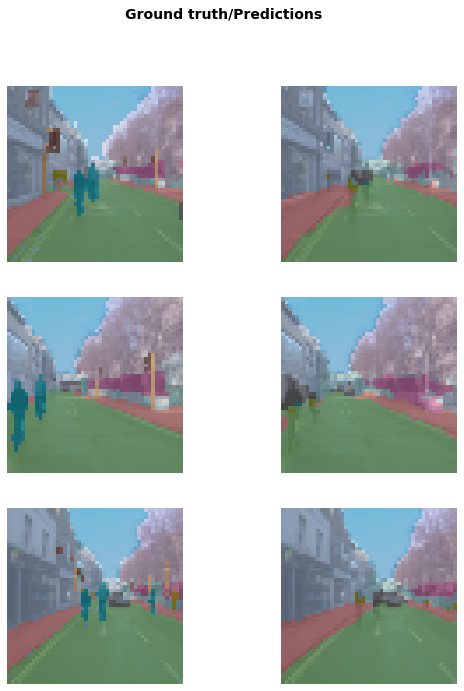

In [16]:
# Visualizing results

learn.show_results(rows=3, figsize=(9,11))

In [17]:
# Extracting Q2 (properly trained output distribution)

scores , preds = learn.get_preds(DatasetType.Train)
f2 = scores.numpy()[:N_EXAMPLES,:,:HEIGHT,:WIDTH]
f2 = f2.reshape(N_EXAMPLES,N_LABELS, PIXELS)
Q2 = f2.mean(axis=0)

# Clear unused vars from RAM
scores = None
preds = None

#### Comparison of results

In [20]:
# KL divergence
def KL(p,q): return np.sum(np.where(p != 0, p * np.log(p / q), 0))

print("KL Divergence between the properly traind and undertrained networks: ",
      KL(Q2,Q))
print("KL Divergence between the properly traind and optimized networks: ",
      KL(Q2,P.value))

KL Divergence between the properly traind and undertrained networks:  135.94873
KL Divergence between the properly traind and optimized networks:  -90.56118298780433
